# Protocolo de Cuantificación de Píxeles GUS-blue (Local)

Este notebook implementa un flujo de trabajo optimizado para la cuantificación automatizada de tinción azul (GUS) en raíces de *Arabidopsis*.

### Características principales:
1. **Optimizado para Local:** Diseñado para ejecutarse en entornos con `uv` o similares.
2. **Normalización por Área:** Calcula el porcentaje (%) de tinción respecto al tamaño total de la raíz.
3. **Reducción de Ruido:** Filtro Gaussiano y limpieza morfológica para resultados precisos.
4. **Batch Processing:** Analiza todas las imágenes en la carpeta 'plant_photos' automáticamente.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

print("Librerías cargadas correctamente para entorno local.")

Librerías cargadas correctamente para entorno local.


## 1. Parámetros de Configuración

Ajusta los rangos HSV según la intensidad de tu tinción y las condiciones de luz.

In [2]:
# Rango HSV para detección de azul (GUS)
# H: 0-179, S: 0-255, V: 0-255
BLUE_LOWER = np.array([90, 40, 40])
BLUE_UPPER = np.array([140, 255, 255])

# Umbral para detección de raíz (ajustar si el fondo no es blanco)
ROOT_S_THRESHOLD = 20  # Saturación mínima
ROOT_V_MAX = 240       # Valor máximo para evitar el fondo blanco

print("Parámetros configurados.")

Parámetros configurados.


## 2. Funciones de Procesamiento

Definición de las funciones core para la segmentación y cuantificación.

In [3]:
def process_gus_image(image_path, blue_lower, blue_upper):
    """
    Procesa una imagen para detectar la raíz y la tinción azul.
    """
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        return None
    
    # 1. Preprocesamiento: Desenfoque Gaussiano para reducir ruido
    blurred = cv2.GaussianBlur(img_bgr, (5, 5), 0)
    
    # Convertir a HSV
    hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)
    
    # 2. Segmentación de la Raíz
    root_mask = cv2.inRange(hsv, np.array([0, ROOT_S_THRESHOLD, 0]), np.array([179, 255, ROOT_V_MAX]))
    
    # 3. Detección de Azul
    blue_mask_raw = cv2.inRange(hsv, blue_lower, blue_upper)
    
    # Solo considerar azul dentro de la raíz
    blue_mask_in_root = cv2.bitwise_and(blue_mask_raw, root_mask)
    
    # 4. Limpieza Morfológica (Apertura para quitar ruido pequeño)
    kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], np.uint8)
    blue_mask_clean = cv2.morphologyEx(blue_mask_in_root, cv2.MORPH_OPEN, kernel)
    
    # Cuantificación
    root_area = np.sum(root_mask > 0)
    blue_area = np.sum(blue_mask_clean > 0)
    percentage = (blue_area / root_area * 100) if root_area > 0 else 0
    
    return {
        'original': cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB),
        'root_mask': root_mask,
        'blue_mask': blue_mask_clean,
        'metrics': {
            'root_pixels': root_area,
            'blue_pixels': blue_area,
            'percentage': percentage
        }
    }

def analyze_batch(image_paths, output_csv="resultados_gus.csv"):
    results = []
    for path in image_paths:
        name = os.path.basename(path)
        print(f"Analizando: {name}")
        data = process_gus_image(path, BLUE_LOWER, BLUE_UPPER)
        
        if data:
            m = data['metrics']
            results.append({
                'Archivo': name,
                'Pixeles_Total_Raiz': m['root_pixels'],
                'Pixeles_Azules': m['blue_pixels'],
                'Porcentaje_Azul': round(m['percentage'], 2)
            })
            
            # Visualización rápida
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            axs[0].imshow(data['original'])
            axs[0].set_title(f"Original: {name}")
            axs[1].imshow(data['root_mask'], cmap='gray')
            axs[1].set_title("Máscara de Raíz")
            axs[2].imshow(data['blue_mask'], cmap='Blues')
            axs[2].set_title(f"Azul: {round(m['percentage'], 2)}%")
            for ax in axs: ax.axis('off')
            plt.show()
            
    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)
    return df

## 3. Ejecución del Análisis

Asegúrate de que tus fotos estén en la carpeta `plant_photos` en el mismo directorio que este notebook.

Buscando imágenes en: d:\CODE\Code3_Coding and Data\20260218_auxine_calculation.md\plant_photos
Se encontraron 2 imágenes.
Analizando: high_blue.jpg


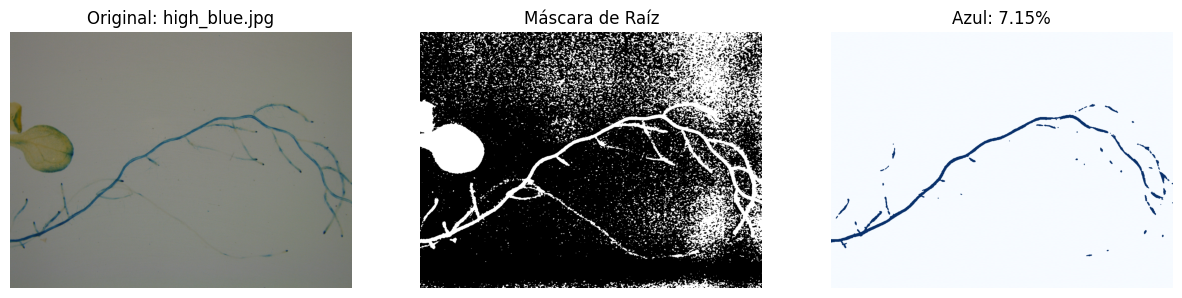

Analizando: low_blue.jpg


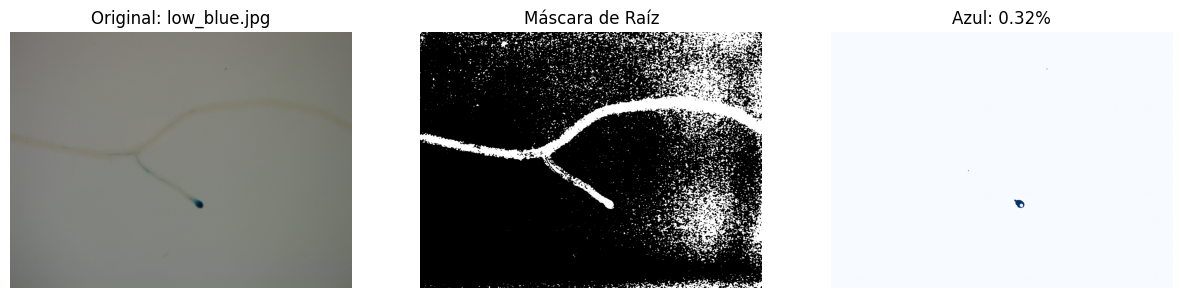


--- Resultados Finales ---
         Archivo  Pixeles_Total_Raiz  Pixeles_Azules  Porcentaje_Azul
0  high_blue.jpg              192467           13764             7.15
1   low_blue.jpg              136175             440             0.32


In [4]:
def get_image_paths(directory):
    exts = ('.png', '.jpg', '.jpeg', '.tif', '.tiff')
    if not os.path.exists(directory):
        return []
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.lower().endswith(exts)]

# BUSCAR IMÁGENES EN LA CARPETA 'plant_photos'
cwd = os.getcwd()
img_dir = os.path.join(cwd, "plant_photos")
print(f"Buscando imágenes en: {img_dir}")

image_paths = get_image_paths(img_dir)

if not image_paths:
    print(f"Error: No se encontraron imágenes en {img_dir}")
    print("Por favor, revisa que la carpeta contenga archivos .jpg o .png.")
else:
    print(f"Se encontraron {len(image_paths)} imágenes.")
    final_df = analyze_batch(image_paths)
    print("\n--- Resultados Finales ---")
    print(final_df)